In [1]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_union, make_pipeline, Pipeline
from sklearn.model_selection import ParameterGrid

from sklearn.impute import MissingIndicator, KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler

from fenginering.function import *
from fenginering.indicator import *
from fenginering.transformer import *
from data.get_data import *

%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.pipeline import FeatureUnion

In [3]:
sma_list = [3, 9, 12]
ema_list = [3, 9, 15]
rsi_list = [10, 14, 20]
atr_list = [3, 6, 9]
adx_list = [3, 6, 9]
sar = []
n_day_up_list = [10, 15, 20]
aroon_list = [5, 10, 15]


stochastic_oscillator_dict = {
    'k_period' : [10, 15, 20],
    'd_period' : [3, 5]
}

bande_bollingers_dict = {
    'window' : [10, 15, 20],
    'wind_dev' : [3, 5]
}

macd_dict = {
    'slow' : [10, 14],
    'fast' : [3, 5],
    'signal' : [2, 3]
}


In [4]:
start = "2022"
end = "2023"
data = get_data('BTC', '1h').loc[start : end]
data.drop(columns = ['symbol'], inplace = True)
data.columns = data.columns.astype(str)
data.shape

(10757, 5)

In [5]:
start = "2022"
end = "2023"
data = get_data('BTC', '1h').loc[start : end]
data.drop(columns = ['symbol'], inplace = True)
data.columns = data.columns.astype(str)
data.shape

Indicators = MakeIndicator(data)
Indicators.set_stransformer(sma, sma_list)
Indicators.set_stransformer(ema, ema_list)
Indicators.set_stransformer(rsi, rsi_list)
Indicators.set_stransformer(atr, atr_list)
Indicators.set_stransformer(n_day_up, n_day_up_list)


#Indicators.set_mtransformer(adx, adx_list)
#Indicators.set_stransformer(aroon, aroon_list)

Indicators.set_mtransformer(macd, macd_dict)
Indicators.set_mtransformer(stochastic_oscillator, stochastic_oscillator_dict)
Indicators.set_mtransformer(bande_bollingers, bande_bollingers_dict)

data = Indicators.df()

# Model

<Axes: >

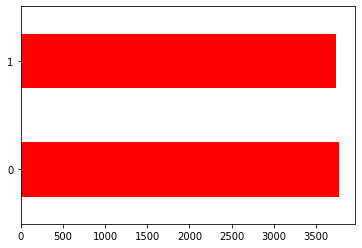

In [6]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

N = data.shape[0]
n = int(0.7*N)
train = data[:n]
test = data[n:]


target = get_classification_target(train)
features = train

target_test = get_classification_target(test)
features_test = test

target.value_counts().plot(kind = 'barh', color = 'red')

In [7]:
from fenginering.selection import *



In [8]:
from sklearn.model_selection import TimeSeriesSplit

exp_cv = TimeSeriesSplit(n_splits = 10)

In [9]:
model = RandomForestClassifier()
model.fit(features, target)

RandomForestClassifier()

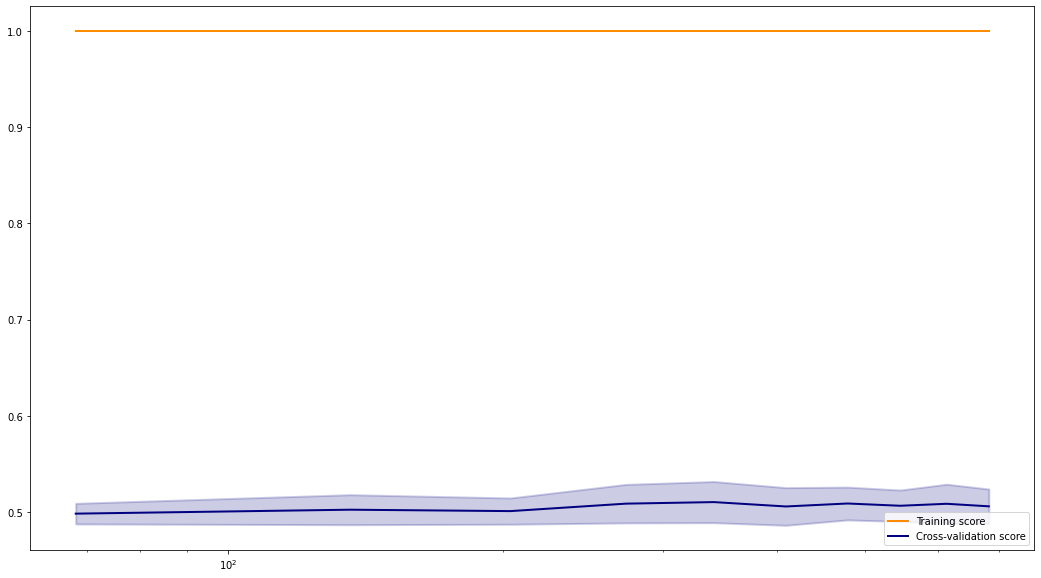

(array([ 68, 136, 204, 273, 341, 409, 478, 546, 614, 683]),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[0.50658858, 0.49048316, 0.51830161, 0.48023426, 0.4875549 ,
         0.50073206, 0.50951684, 0.49926794, 0.49780381, 0.49194729],
        [0.51537335, 0.49487555, 0.53879941, 0.50951684, 0.49487555,
         0.49780381, 0.48462665, 0.48169839, 0.50512445, 0.50073206],
        [0.51537335, 0.51976574, 0.522694  , 0.48316252, 0.49341142,
         0.48169839, 0.50366032, 0.49780381, 0.49780381, 0.49341142],
        [0.53879941, 

In [13]:
from evaluation.curve import learningCurve
from sklearn.model_selection import TimeSeriesSplit

exp_cv = TimeSeriesSplit(n_splits = 10)
learningCurve(model, features, target, exp_cv)

 Accuracy : 0.50 
 f1 : 0.52 
 precision : 0.51 
 recall : 0.53 
 AUC : 0.50 
              precision    recall  f1-score   support

           0       0.49      0.47      0.48      1570
           1       0.51      0.53      0.52      1651

    accuracy                           0.50      3221
   macro avg       0.50      0.50      0.50      3221
weighted avg       0.50      0.50      0.50      3221



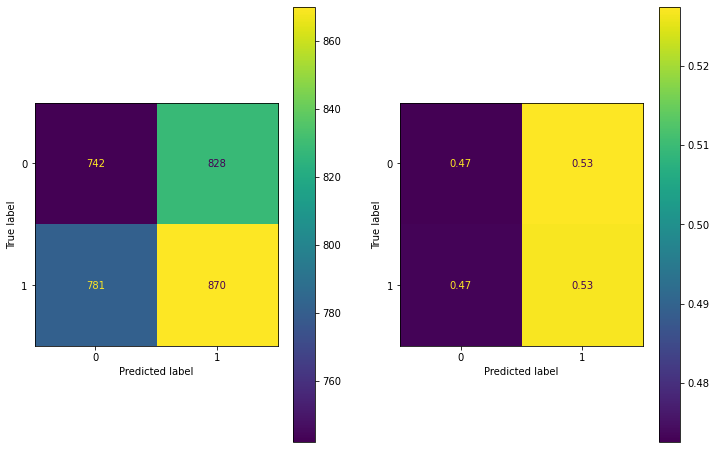

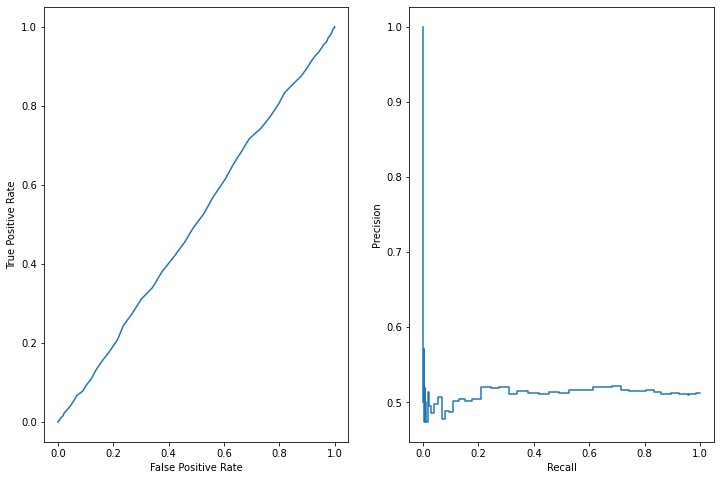

In [14]:
y_pred = model.predict(features_test)
y_pred_proba = model.predict_proba(features_test)

from evaluation.classification import *

evaluation = Evaluation(y_true = target_test, y_pred = y_pred, proba_pred = y_pred_proba[:,1])
evaluation.metrics()
evaluation.show()

In [ ]:
Importance = pd.DataFrame({'Importance' : model.feature_importances_*100},
                          index = model.feature_names_in_)
Importance.sort_values('Importance', axis = 0, ascending = True).plot(kind = 'barh', color = 'r')

In [ ]:
import joblib
#joblib.dump(model, 'model/model.joblib')

In [ ]:
import plotly.express as px
px.box(y_pred_proba)

# backtest

In [ ]:
def backtest(features_test, target_test):
    backtest = pd.DataFrame()
    backtest['close'] = features_test.close
    backtest['returns'] = features_test.close.pct_change()
    backtest['target'] = target_test
    backtest['pred'] = y_pred

    backtest['cum_ret'] = (1 + backtest['returns']).cumprod()

    backtest['strategy'] = backtest['returns']*backtest['pred']
    backtest['strategy_cum_ret'] = (1 + backtest['strategy']).cumprod()
    
    backtest[['cum_ret', 'strategy_cum_ret']].plot(figsize = (15, 10))
    

In [ ]:
backtest(features_test, target_test)

In [ ]:
y_pred_proba[:,1]

In [ ]:
lev = 100

up = 0.7
down = 0.3

backtest = pd.DataFrame()

backtest['close'] = features_test.close
backtest['returns'] = features_test.close.pct_change()
backtest['target'] = target_test
backtest['pred'] = y_pred
backtest['pred_proba'] = y_pred_proba[:,0]

backtest['pred2'] = np.where(backtest['pred_proba'] > 0.7, 1,
         np.where(backtest['pred_proba'] < 0.3, -1, 0)
         )

backtest['cum_ret'] = (1 + backtest['returns']).cumprod()

backtest['strategy'] = backtest['returns']*backtest['pred']
backtest['strategy_cum_ret'] = (1 + backtest['strategy']).cumprod()

backtest['leverage'] = np.where(backtest['pred_proba'] > 0.8, lev,
                                np.where(backtest['pred_proba'] < 0.2, lev, 1)
                                )
backtest['strategy2'] = backtest['returns'] * backtest['pred2'] * backtest['leverage']


backtest['strategy_cum_ret2'] = (1 + backtest['strategy2']).cumprod()

#backtest

#backtest[['cum_ret', 'strategy_cum_ret', 'strategy_cum_ret2']].plot(figsize = (15, 10))
px.line(backtest[['cum_ret', 'strategy_cum_ret', 'strategy_cum_ret2']])

# CrossOver

In [ ]:
start = "2022"
end = "2023"
data = get_data('BTC', '1d').loc[start : end]
data.drop(columns = ['symbol'], inplace = True)
data.columns = data.columns.astype(str)
data.shape

In [ ]:
macd(data, 14, 7, 3)

In [ ]:
(ema(data, 14) - ema(data, 7))

In [ ]:
from fenginering.preprocessing import CrossOver

cross = Crossover(data)
cross.ma(sma, sma_list)
